In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import seaborn as sns


In [3]:
# Load the dataset
file_path = "Sleep_health_and_lifestyle_dataset.csv"
df = pd.read_csv(file_path)

# Display basic information and the first few rows
df_info = df.info()
df_head = df.head()
df_description = df.describe(include='all')

df_head, df_description

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 374 entries, 0 to 373
Data columns (total 13 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Person ID                374 non-null    int64  
 1   Gender                   374 non-null    object 
 2   Age                      374 non-null    int64  
 3   Occupation               374 non-null    object 
 4   Sleep Duration           374 non-null    float64
 5   Quality of Sleep         374 non-null    int64  
 6   Physical Activity Level  374 non-null    int64  
 7   Stress Level             374 non-null    int64  
 8   BMI Category             374 non-null    object 
 9   Blood Pressure           374 non-null    object 
 10  Heart Rate               374 non-null    int64  
 11  Daily Steps              374 non-null    int64  
 12  Sleep Disorder           155 non-null    object 
dtypes: float64(1), int64(7), object(5)
memory usage: 38.1+ KB


(   Person ID Gender  Age            Occupation  Sleep Duration  \
 0          1   Male   27     Software Engineer             6.1   
 1          2   Male   28                Doctor             6.2   
 2          3   Male   28                Doctor             6.2   
 3          4   Male   28  Sales Representative             5.9   
 4          5   Male   28  Sales Representative             5.9   
 
    Quality of Sleep  Physical Activity Level  Stress Level BMI Category  \
 0                 6                       42             6   Overweight   
 1                 6                       60             8       Normal   
 2                 6                       60             8       Normal   
 3                 4                       30             8        Obese   
 4                 4                       30             8        Obese   
 
   Blood Pressure  Heart Rate  Daily Steps Sleep Disorder  
 0         126/83          77         4200            NaN  
 1         125/80 

### Data Exploration

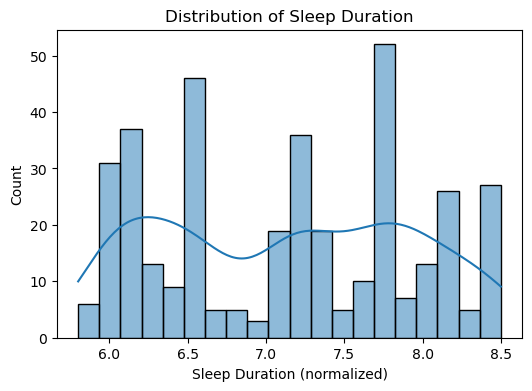

In [5]:
# Histogram for Sleep Duration
plt.figure(figsize=(6,4))
sns.histplot(df['Sleep Duration'], bins=20, kde=True)
plt.title('Distribution of Sleep Duration')
plt.xlabel('Sleep Duration (normalized)')
plt.ylabel('Count')
plt.show()

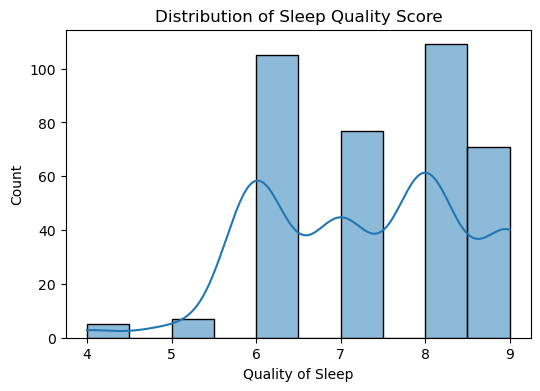

In [6]:
# Histogram for Quality of Sleep
plt.figure(figsize=(6,4))
sns.histplot(df['Quality of Sleep'], bins=10, kde=True)
plt.title('Distribution of Sleep Quality Score')
plt.xlabel('Quality of Sleep')
plt.ylabel('Count')
plt.show()


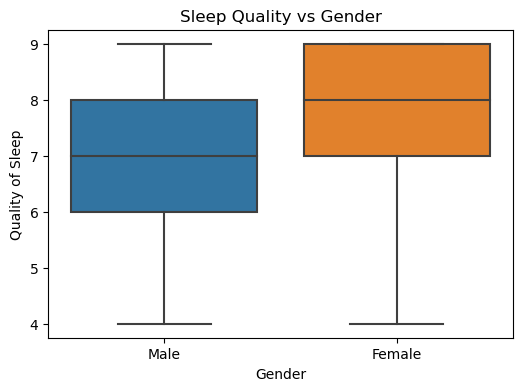

In [7]:
# Boxplot for Sleep Quality vs Gender
plt.figure(figsize=(6,4))
sns.boxplot(x='Gender', y='Quality of Sleep', data=df)
plt.title('Sleep Quality vs Gender')
plt.xlabel('Gender')
plt.ylabel('Quality of Sleep')
plt.show()

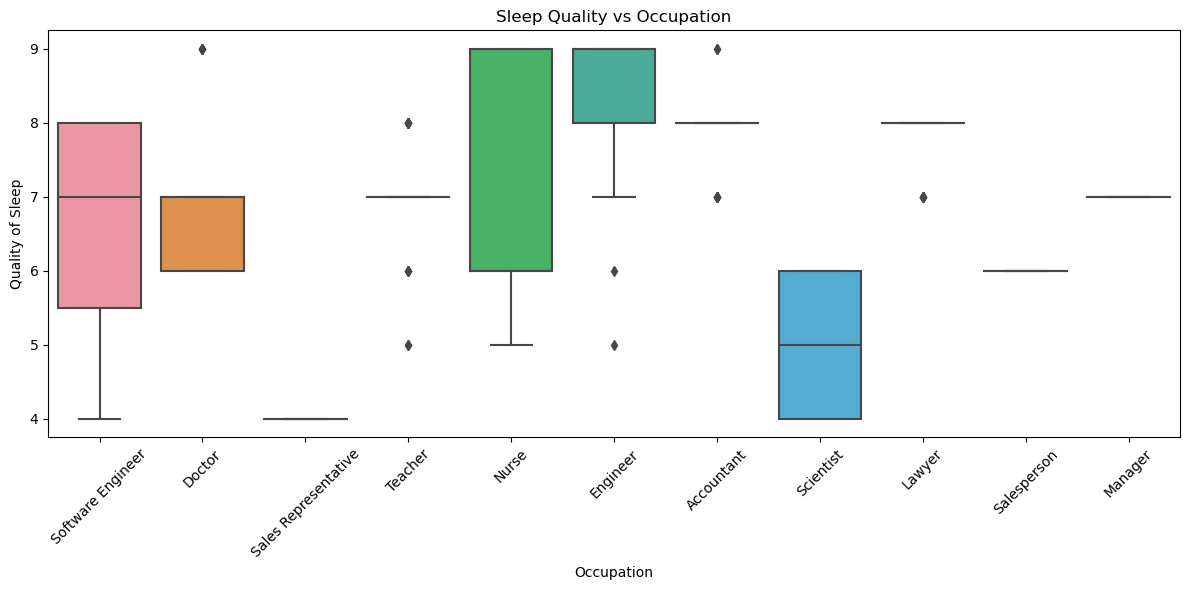

In [8]:
# Boxplot for Sleep Quality vs Occupation
plt.figure(figsize=(12,6))
sns.boxplot(x='Occupation', y='Quality of Sleep', data=df)
plt.title('Sleep Quality vs Occupation')
plt.xlabel('Occupation')
plt.ylabel('Quality of Sleep')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

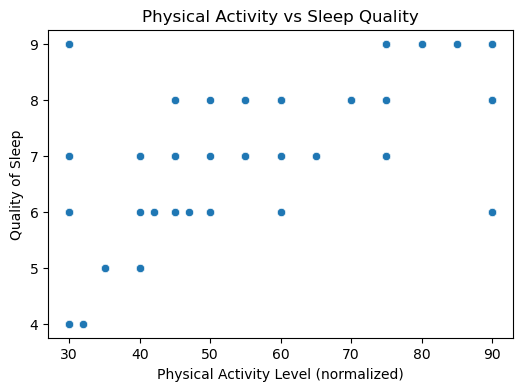

In [9]:
# Scatter Polt Physical Activity vs Sleep Quality
plt.figure(figsize=(6,4))
sns.scatterplot(x='Physical Activity Level', y='Quality of Sleep', data=df)
plt.title('Physical Activity vs Sleep Quality')
plt.xlabel('Physical Activity Level (normalized)')
plt.ylabel('Quality of Sleep')
plt.show()

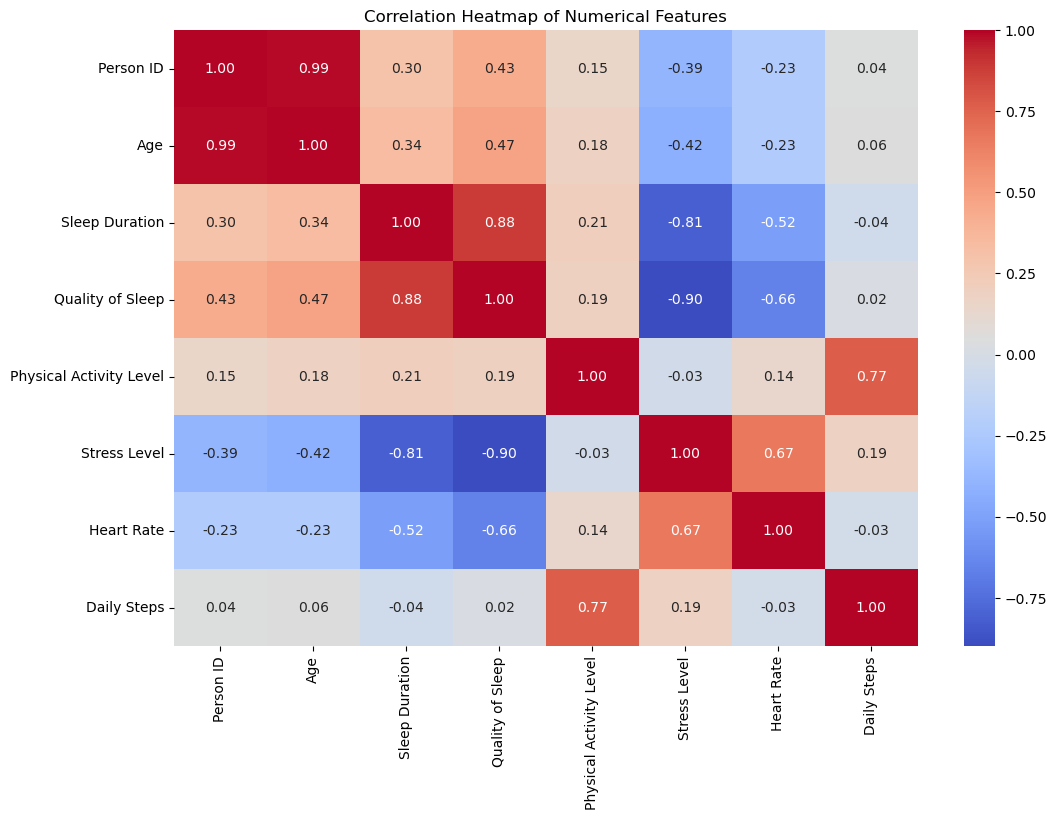

In [10]:
# Correlation HeaT Map
plt.figure(figsize=(12, 8))
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap of Numerical Features')
plt.show()

### Data Preprocessing

In [12]:
# Split Blood Pressure into Systolic &Diastolic
df[['Systolic_BP', 'Diastolic_BP']] = df['Blood Pressure'].str.split('/', expand=True).astype(int)

# Drop unused colummns
df.drop(columns=['Person ID', 'Blood Pressure'], inplace=True)

In [13]:
# One-Hot Encoding for Categorical Column
df = pd.get_dummies(df, columns=['Gender', 'Occupation', 'BMI Category'], drop_first=True, dtype=int)

In [14]:
# Handle Missing Values
# Numerical --> Median Imputation
for col in df.select_dtypes(include=['float64', 'int64']).columns:
    df[col].fillna(df[col].median(), inplace=True)
# Catgorical --> Mode Imputation
for col in df.select_dtypes(include=['object']).columns:
    df[col].fillna(df[col].mode()[0], inplace=True)

In [15]:
# Min-Max Scaling for Numerical Features
scaler = MinMaxScaler()
numerical_cols = ['Age', 'Sleep Duration', 'Physical Activity Level',
                  'Stress Level', 'Heart Rate', 'Daily Steps', 'Systolic_BP', 'Diastolic_BP']
df[numerical_cols] = scaler.fit_transform(df[numerical_cols])

In [16]:
# Cap outliers in numerical columns using IQR
def cap_outliers_iqr(df, cols):
    for col in cols:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        df[col] = df[col].clip(lower_bound, upper_bound)
    return df

# Columns to cap
numerical_cols = ['Age', 'Sleep Duration', 'Physical Activity Level',
                  'Stress Level', 'Heart Rate', 'Daily Steps',
                  'Systolic_BP', 'Diastolic_BP']

df = cap_outliers_iqr(df, numerical_cols)

In [17]:
# Drop one feature from pairs with correlation > 0.8
# corr_matrix = df.corr(numeric_only=True).abs()
# upper = corr_matrix.where(~np.tril(np.ones(corr_matrix.shape)).astype(bool))
# to_drop = [column for column in upper.columns if any(upper[column] > 0.8)]

# df.drop(columns=to_drop, inplace=True)
# print("Dropped columns due to high correlation:", to_drop)


In [18]:
from sklearn.decomposition import PCA

# Apply PCA to numerical columns (after scaling)
pca_cols = df.select_dtypes(include=['float64', 'int64']).columns
pca = PCA(n_components=0.95)  # retain 95% variance
principal_components = pca.fit_transform(df[pca_cols])

# Convert to DataFrame if you want to use it instead
pca_df = pd.DataFrame(principal_components, columns=[f'PC{i+1}' for i in range(principal_components.shape[1])])

In [19]:
# Feature Engineering
df['Sleep Efficiency'] = df['Quality of Sleep'] / (df['Sleep Duration'] + 1e-5)
df['Stress_Activity_Ratio'] = df['Stress Level'] / (df['Physical Activity Level'] + 1e-5)

In [20]:
# Export the preprocessed DataFrame to Excel
output_path = 'Preprocessed_Sleep_Health_Dataset.xlsx'
df.to_excel(output_path, index=False)

output_path

'Preprocessed_Sleep_Health_Dataset.xlsx'

In [21]:
# Final Check
print("Dataset Shape:", df.shape)
print(df.head())
print(df.info())
print(df.describe())

Dataset Shape: (374, 26)
       Age  Sleep Duration  Quality of Sleep  Physical Activity Level  \
0  0.00000        0.111111                 6                      0.2   
1  0.03125        0.148148                 6                      0.5   
2  0.03125        0.148148                 6                      0.5   
3  0.03125        0.037037                 4                      0.0   
4  0.03125        0.037037                 4                      0.0   

   Stress Level  Heart Rate  Daily Steps Sleep Disorder  Systolic_BP  \
0           0.6    0.571429     0.171429    Sleep Apnea     0.407407   
1           1.0    0.476190     1.000000    Sleep Apnea     0.370370   
2           1.0    0.476190     1.000000    Sleep Apnea     0.370370   
3           1.0    0.619048     0.000000    Sleep Apnea     0.925926   
4           1.0    0.619048     0.000000    Sleep Apnea     0.925926   

   Diastolic_BP  ...  Occupation_Sales Representative  Occupation_Salesperson  \
0          0.40  ...  